<a href="https://colab.research.google.com/github/fukuta-takenaka/pub_colab/blob/main/tutorial_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 画像分類実践

ページ上部の ランタイム → ランタイムのタイプを変更 → ハードウェアアクセラレータを「GPU」に変更 → 保存  
深層学習では、簡単な計算を大量に行い学習を進めます。こういった計算にはGPUが適しています。

### パッケージの準備

In [ ]:
# 必要なパッケージをインストール
# !から始まる行はshell command (Pythonではない)
!pip install icrawler

%matplotlib inline
import matplotlib.pyplot as plt

### webから画像をかき集める：クローリング

今回は猫・犬の画像分類器を作成します。猫と犬の画像が必要なので、webからかき集めてきます。収集した画像はランタイムのディスク領域に保存されるため、ランタイムのセッションを閉じると削除されます。

In [ ]:
from icrawler.builtin import BingImageCrawler
import logging

n_img = 200

# 猫の画像を取得
crawler = BingImageCrawler(storage={"root_dir": "cat"}, log_level=logging.INFO, parser_threads=2, downloader_threads=4,)
crawler.crawl(keyword="猫", max_num=n_img)

# 犬の画像を取得
crawler = BingImageCrawler(storage={"root_dir": "dog"}, log_level=logging.INFO, parser_threads=2, downloader_threads=4,)
crawler.crawl(keyword="犬", max_num=n_img)

### 収集した画像の読み込み

画像をopencv (`cv2`) というモジュールで読み込みます。画像は`numpy`の`np.ndarray`という配列オブジェクトとして読み込まれます。  
`ndarray`で気にかけておくべきことは次の3つです。
- 配列の次元 = ランク (`ndarray.ndim`)
- 配列の形 (`ndarray.shape`)
- 配列のデータ型 (`ndarray.dtype`)  

一方で中身の個々の値に関しては、大きい配列ですと確認が難しいため、最大値や平均値など配列全体としての情報から期待している数値が入っているか推測することになります。

<img src="https://qph.fs.quoracdn.net/main-qimg-30be20ab9458b5865b526d287b4fef9a" width="500" >

低次元の配列には名前がついています。
- 0次元: スカラー
- 1次元: ベクトル
- 2次元: マトリックス

これらを一般化した概念をテンソルと呼びます。

In [3]:
# ダウンロードした画像を全て同じ大きさにリサイズし、メモリに格納
import numpy as np
import cv2
from pathlib import Path  # ディスク上のファイル一覧を取得するなど、パスの操作に用いるモジュール

img_size = 64
imgs_cat = list()
imgs_dog = list()

for img_list, img_dir in ((imgs_cat, './cat'), (imgs_dog, './dog')):
  # 画像パス一つずつを処理
  for impath in Path(img_dir).iterdir():
    # 画像読み込み: cv2.imread()
    img = cv2.imread(str(impath))
    # 画像リサイズ
    img = cv2.resize(img, (img_size, img_size))
    img_list.append(img)

# listをndarrayに変換
imgs_cat = np.array(imgs_cat)
imgs_dog = np.array(imgs_dog)

# テンソルの情報を確認
print(imgs_cat.ndim)
print(imgs_cat.shape)
print(imgs_cat.dtype)
print('')
print(imgs_dog.ndim)
print(imgs_dog.shape)
print(imgs_dog.dtype)

4
(180, 64, 64, 3)
uint8

4
(151, 64, 64, 3)
uint8


`cv2.imread()`関数で読み込んだ画像のデータ型は、デフォルトでは`np.uint8`という、符号なし（=マイナスを表現できない）8 bitの整数です。[0, 255]の範囲のみ表現可能です。  
`imgs_cat`は4次元配列で形が(n, 64, 64, 3)になっています。これは、最初の軸 (`axis = 0`) には画像の枚数nが、続く3つの次元には64 x 64 pixelの3チャネル (RGB) 画像が格納されているという意味になっています。  
(`cv2.imread()`で読み込んだ画像は、厳密にはチャネルの並びがBGRの順番になっています。)

### 収集した画像の確認

読み込んだ画像をタイル状に並べて確認します

In [4]:
# 画像の一覧可視化関数
import math
import PIL

def tile_show(imgs, n_col=10):
  h, w = imgs[0].shape[:2]
  assert all([img.shape[:2] == (h, w) for img in imgs])
  n_row = math.ceil(len(imgs) / n_col)
  tile = np.zeros((h*n_row, w*n_col, 3), np.uint8)
  for i, img in enumerate(imgs):
    row = i // n_col
    col = i % n_col
    y1 = row * h
    y2 = (row+1) * h
    x1 = col * w
    x2 = (col+1) * w
    tile[y1:y2, x1:x2] = img
  
  return PIL.Image.fromarray(tile[..., ::-1])

In [ ]:
tile_show(imgs_cat)

In [ ]:
tile_show(imgs_dog)

### 学習データ・テストデータの作成

収集した画像を学習用とテスト用（精度評価用）に分け、ラベル（正解）を付与する。  
猫=0、犬=1とする。


画像処理では、入力画像を少数で[-1, 1]の範囲に正規化して用いることが多い。すなわち、`np.uint8`[0, 255]を`np.float32`[-1, 1]に変換する。

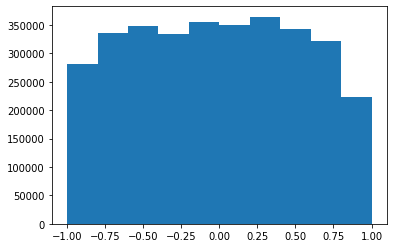

In [23]:
# 学習データとテストデータの作成
test_rate = 0.2
n_cat_test = int(len(imgs_cat) * test_rate)
n_dog_test = int(len(imgs_dog) * test_rate)

cat_test, cat_train = imgs_cat[:n_cat_test], imgs_cat[n_cat_test:]
dog_test, dog_train = imgs_dog[:n_dog_test], imgs_dog[n_dog_test:]

# ndarrayの結合, dtypeをfloat32に変更, [-1,1]に正規化
train_X = np.concatenate([cat_train, dog_train], axis=0).astype(np.float32)
train_X = ((train_X / 255.) - 0.5) * 2
test_X = np.concatenate([cat_test, dog_test], axis=0).astype(np.float32)
test_X = ((test_X / 255.) - 0.5) * 2

# 正規化の確認。train_Xに含まれる全画素の輝度のヒストグラム
plt.hist(train_X.flatten())

# ラベルを作成。猫=0、犬=1として設定
train_y = np.array([0.] * len(cat_train) + [1.] * len(dog_train)).astype(np.float32)
test_y = np.array([0.] * len(cat_test) + [1.] * len(dog_test)).astype(np.float32)


### モデルの作成

今回はVGG16という畳み込みニューラルネットワークを用います。  
有名なモデルはtensorflwoフレームワークに組み込まれており、呼び出すだけでモデルが使用できます。

In [15]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16

vgg = VGG16(include_top=True, weights=None, input_shape=(img_size, img_size, 3), classes=1)
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

  `tf.keras.Model.summary()`メソッドでは、モデルの各レイヤーのテンソルの形が表示されます (`None`は数値が任意であることを示す) 。モデルを1つの大きな関数として考えた時、重要なのは入力と出力です。  
- input:  `input_5 (InputLayer)        [(None, 64, 64, 3)]`  
- output:   `predictions (Dense)         (None, 1)`

このモデルは、「4次元テンソルを入力されると2次元テンソルを出力する関数」と言えます。さらに、出力の形が`(None, 1)`であるため、実質的には出力を1次元テンソル = ベクトルと考えることができます。



#### ニューラルネットワーク

<img src="https://www.esector.co.jp/bpa/img/A19-034.png" width="500">
<a href="https://www.esector.co.jp/bpa/A19-034.html">src</a>

ニューロンに対応する部分をノードなどと呼ぶ。たいてい1ノードだけで扱うことはなく、層のような構造に例えられるためレイヤーとも呼ばれる

<img src="https://www.imagazine.co.jp/wp-content/uploads/2018/07/086-090_16ISno13_kiso_deep_zu003.jpg" width="500">
<a href="https://www.imagazine.co.jp/%E7%95%B3%E3%81%BF%E8%BE%BC%E3%81%BF%E3%83%8D%E3%83%83%E3%83%88%E3%83%AF%E3%83%BC%E3%82%AF%E3%81%AE%E3%80%8C%E5%9F%BA%E7%A4%8E%E3%81%AE%E5%9F%BA%E7%A4%8E%E3%80%8D%E3%82%92%E7%90%86%E8%A7%A3%E3%81%99/">src</a>

畳み込みニューラルネットワーク（CNN）は、神経細胞の発火のルールを、画像の部分領域をベースにしたという点で、人間の視覚処理により近い構造を模していると考えることができる。

#### 畳み込み処理

<img src="https://axa.biopapyrus.jp/media/CNN_Conv3.png" width="500"><a href="https://axa.biopapyrus.jp/deep-learning/cnn/convolution.html">src</a>

中央の3x3の配列をfilter, kernel, windowなどと呼ぶ。畳み込みは特定のパターン（模様）を抽出する操作だと考えることもでき、フィルターの内容がパターンを決定する。CNNでは、フィルターの中身を学習によって更新し、学習がうまく進むと画像内の特徴量（猫らしさ、犬らしさの指標になる模様など）が抽出できるようになる。


<img src="https://i.stack.imgur.com/wrxLE.png" width="500"><a href="http://web.pdx.edu/~jduh/courses/Archive/geog481w07/Students/Ludwig_ImageConvolution.pdf">src</a>  
カーネルの違いによる畳み込み効果の例

### モデルの学習